## A ***naive*** contextual-bandit approach to advertisment using $\epsilon$-greedy research

In a contextual-bandit approach the State is used in order to make an action, but the State is not directly influenced by previous actions.

Given a set of $k$ actions and a state $S_t$, the problem requieres to maximize the total reward.
In this example, each action is represented by an item, that can choosen to be shown to the user as an advert. The state represent the actaul web page the user is visiting.
Each item has a certain probability of being clicked, returning a reward in that case.



The $R_t$ vector represents the rewards for every action. Every state has a different $R_t$, for a specific web page a particular item could be more appreciated. In order to provide a simulation of an user interests, a reward vector has been generated with absolute value from a normal distribution with $\mu=0.3$ , $\sigma^2=0.2$, introducing some variations for every state.

The estimation vector $Q_t$ is initilized in an optimistic way, givin the maximum value to every item. Then the estimation is updated as an average of the received rewards for every item, incrementally. 
$N_t$ counts the number of time an action has been selected.

In [74]:
import numpy as np
%matplotlib inline

rnd = np.random
rnd.seed(42)

# State vector, representing web pages
S  = ["Linkedin", "StackOverflow", "TheGuardian", "Youtube", "Github", "Lolalytics"]

state_idx = 0

# List of items
items = ["Car", "Watch", "T-shirt", "Computer", "Smartphone", 
         "Headphones", "Sunglasses", "NordVPN", "HogwardsLegacy"]

# The estimation's vector
Q = [1 for item in range(len(items))]

# Counter of the times that item has been chosen
N = np.ones(len(items))

# The rewards' probabilities vector
R = [np.round(np.abs(rnd.normal(0.3,0.2)), 2) for item in range (len(items))]

# Variation of rewards based on state
R_s = [[np.round(reward + rnd.normal(0,1)/10, 2) for reward in R] for _ in S]

The rewards' probabilities slightly change in different states. 

[]

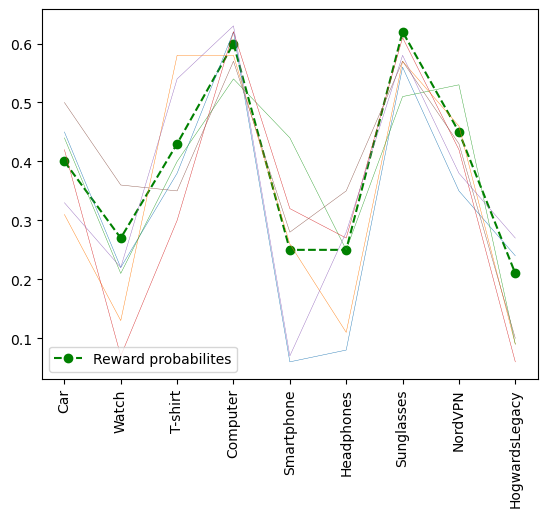

In [75]:
from matplotlib import pyplot as plt

plt.plot(R, "o--g",label="Reward probabilites")
for reward in R_s:
    plt.plot(reward, linewidth=0.3)
plt.xticks(ticks= np.arange(0,9), labels=items, rotation=90)
plt.legend()
plt.plot()

Tuning parameters

An higher $\epsilon$ value will increase the exploration, resulting in a better  estimation of all the items overall. A lower value, will focus the algorithm to exploit as much as possible, resulting in an higher confidence estimation for the best one, but in a general bad approximation for the other items' estimations.

In [76]:
# Total number of iterations
ITERATIONS = int(10e5)

# Change state degree
FSTATE = 0.2

# Set the epsilon value for the epsilon-greedy search
EPSILON = 0.15

# The step value
ALPHA = 0.05

Upper-Confidence-Bound

In the non-greedy selection in exploration phase, instead of randomly pick an item, is possible to consider the optimal potential of other actions.
A possible way:
$A_t = \argmax(Q_t(a) + c\sqrt{\frac{\ln(t)}{N_t(a)}})$ 

In [77]:
# Switch to activate UCB selection
UCB = True

# exploration degree
C_DEGREE = EPSILON

Routine definition

In [78]:
from typing import List

def update_state(S: List,
                current: int):
    '''
        Return the index of the new state.

        Parameters
        ----------
        S: List
            States' vector
        current: int
            Index of the current state
    '''

    return rnd.randint(0, len(S)) if rnd.random() < FSTATE else current 

In [79]:
def update_estimation(est: float, 
                    reward: float,
                    step_size: int):
    '''
        Update the estimation, incrementally.

        Parameters
        ----------
        est: float
            Current estimation
        reward: float
            New reward obtained
        step_size: int 
            The inverse of the total number of rewards received if a stationary problem is considered. 
            Otherwise an alpha value (0,1].        
    '''

    return np.round(est + step_size*(reward - est),2)

In [80]:
def select_action(epsilon: float, 
                Q: List,
                N: List,
                c: int = 0,
                t: int = 1,
                UCB: bool = False):
    '''
        Select the next action (item to be shown).

        Parameters
        ----------
        epsilon: float
        Q: List
            Estimation of the value of each action
        N: List
            Counter of times an action has been selected
        c: int
            Used in UCB selection, controls the degree exploration
        t: int
            Time indicator (iterations)
        UCB: bool
            If True UCB selection is done 
    '''
    
    # Check epsilon's value
    if rnd.random() < epsilon:
        # Exploitation
        idx = rnd.randint(0,len(items))
    else: #Explore 
        if not UCB: idx = np.argmax(Q, 0)
        else: 
            estimations_UCB = [Q[i] + c*np.sqrt(np.log(t)/N[i]) for i in range(len(Q))]
            idx = np.argmax(estimations_UCB)
    
    return idx

In [81]:
# A sample item will be tracked
hstry_idx = 8
hstry = np.ones(ITERATIONS)


for step in range(1, ITERATIONS):

    #Update the state 
    state_idx = update_state(S, state_idx)

    idx = select_action(EPSILON, Q, N, C_DEGREE, step, UCB)

    # Get the reward, considering the relative item's probability to give it
    reward = 1 if rnd.rand() < R[idx] else 0

    # Update the counter
    N[idx]+=1

    # Use 1/N instead of ALPHA for the stationary problem    
    Q[idx] = update_estimation(Q[idx], reward, ALPHA)

    # Update the history of the sample item
    hstry[step] = Q[hstry_idx]

Text(0, 0.5, 'Value')

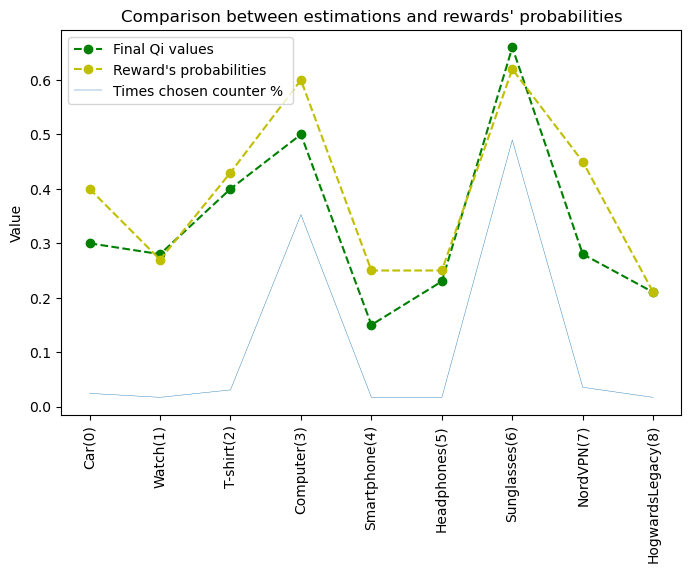

In [82]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Comparison between estimations and rewards' probabilities")
plt.plot(Q, "o--g")
plt.plot(R, "o--y")
plt.plot(N/ITERATIONS, "-",linewidth=0.3)

plt.legend(["Final Qi values", "Reward's probabilities", "Times chosen counter % "])
plt.xticks(ticks= np.arange(0,9), labels=[ f'{items[i]}({i})' for i in np.arange(0,9)], rotation=90)

plt.ylabel("Value")

Text(0, 0.5, 'Value')

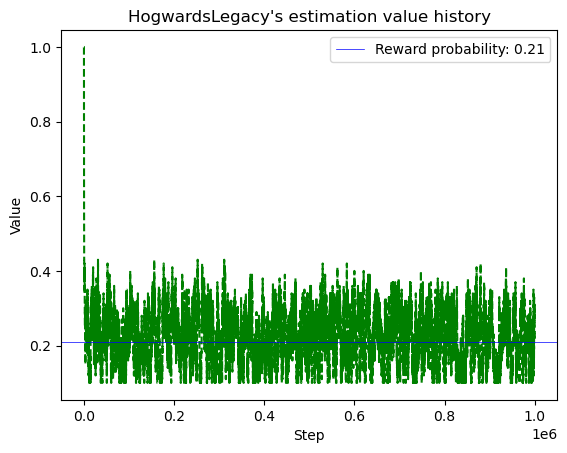

In [83]:
plt.plot(hstry, "--g")
plt.axhline(R[hstry_idx], color = "b", linewidth="0.5", label=f"Reward probability: {R[hstry_idx]}")
plt.legend()
plt.title(f"{items[hstry_idx]}'s estimation value history")
plt.xlabel("Step")
plt.ylabel("Value")
